In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import torch.optim.lr_scheduler

In [2]:
torch.cuda.is_available()

True

In [3]:
dlong = torch.cuda.LongTensor
dfloat = torch.cuda.FloatTensor
batch_size = 128
input_size = 30
hidden_size = 128
n_layers = 1
iter_print = 500
num_epoch = 50

In [4]:
def read_file(filename):
    file = open(filename, 'r')
    out = str()
    for line in file:
        if line[:7] == "<start>":
            out += "$\n"
        elif line[:5] == "<end>":
            out += "%\n"
        else:
            out += line
    return out, len(out)

In [5]:
char_to_indx = {}
indx_to_char = {}
def char_to_index(file):
    length = 0
    for char in file:
        if char not in char_to_indx:
            char_to_indx[char] = length
            length += 1
    return length

def index_to_char(to_indx):
    for char in to_indx:
        indx_to_char[to_indx[char]] = char

In [6]:
def prepare_data(data, to_indx):
    indices = [to_indx[w] for w in data]
    return indices

In [7]:
def get_train_valid(length, train_size = 0.8):
    split = int(np.ceil(train_size*length))
    train_start = 0
    train_end = split
    valid_start = split
    valid_end = length
    return train_start, train_end, valid_start, valid_end

In [8]:
def print_str(seq):
    st = ""
    for i in seq:
        st += indx_to_char[i]
    print(st)

In [9]:
file_addr = 'input.txt'
file, file_len = read_file(file_addr)
output_size = char_to_index(file)
index_to_char(char_to_indx)

file_indx = np.array(prepare_data(file, char_to_indx))
train_start, train_end, valid_start, valid_end = get_train_valid(file_len)

In [10]:
def prepare_sequence(seq, output_s):
    code = (np.arange(output_s) == seq[...,None])
    code = np.array(code, dtype = int)
#     print("lala",code.reshape(3*2,-1))
#     print(np.argmax(code.reshape(3*2,-1),1))
    return code

In [11]:
def random_slice(is_train, input_s, batch_s, output_s):
    if is_train:
        start_indx = np.random.randint(train_start, train_end-input_s, (batch_s,1))
    else:
        start_indx = np.random.randint(valid_start, valid_end-input_s, (batch_s,1))
    indices = np.tile(np.arange(input_s+1),(batch_s,1)) + start_indx
    sequences = file_indx[indices].T
    
#     print(sequences.T)
#     print(file_indx[indices])
#     print_str(file_indx[indices][0])
#     print(prepare_sequence(sequences[:-1],output_s))
    
#     print(sequences[1:].reshape(input_s*batch_s,-1))
#     print(sequences[:-1])
#     print(sequences[:-1].reshape(input_s*batch_s))
    
    target = torch.from_numpy(sequences[1:])
#     print(target)
    inp = torch.from_numpy(prepare_sequence(sequences[:-1],output_s))
    return inp, target

In [12]:
class TestRNN(nn.Module):
    def __init__(self, input_s, hidden_s, batch_s, model="lstm", n_layers=1,dropout=0):
        super(TestRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_s
        self.hidden_size = hidden_s
        self.batch_size = batch_s
        self.n_layers = n_layers
        self.dropout = dropout
        self.hidden = None
        
        if self.model == "lstm":
            self.rnn = nn.LSTM(output_size, self.hidden_size, self.n_layers, dropout=self.dropout)
        elif self.model == "gru":
            self.rnn = nn.GRU(output_size,self.hidden_size, self.n_layers, dropout=self.dropout)
        self.out = nn.Linear(self.hidden_size, output_size)
        self.drop=nn.Dropout(p=self.dropout)
    
    def forward(self, inputs):
        output, self.hidden = self.rnn(inputs, self.hidden)
#         print("xx",output)
#         print("yy",output.view(self.input_size*self.batch_size, -1))
        outputs = self.out(self.drop(output.view(self.input_size*self.batch_size, -1)))
        return outputs
    
    def init_hidden(self, batch_size):
        if self.model == "lstm":
            self.hidden = (autograd.Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_size)).type(dfloat),
                   autograd.Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_size)).type(dfloat))
        else:
            self.hidden = autograd.Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_size).type(dfloat))

In [13]:
def evaluation(is_train, num):
    loss_ave = 0.0
    for n in range(num):
        lstmNet.init_hidden(batch_size)
        inputs, target = random_slice(is_train, lstmNet.input_size, lstmNet.batch_size,output_size)
        inputs = autograd.Variable(inputs.type(dfloat))
        target = autograd.Variable(target.type(dlong)).view(lstmNet.input_size*lstmNet.batch_size)
        output = lstmNet(inputs)
        loss_ave += criterion(output, target).data[0]
    loss_ave /= num
    return loss_ave

In [16]:
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.2).type(dfloat)
optimizer = optim.Adam(lstmNet.parameters(), lr=1e-3)
# optimizer = optim.RMSprop(lstmNet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.5, last_epoch=-1)
criterion = nn.CrossEntropyLoss().type(dfloat)

In [15]:
lstmNet

TestRNN (
  (rnn): LSTM(95, 128, dropout=0.2)
  (out): Linear (128 -> 95)
)

In [14]:
def train_process(num_epochs):
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    train_loss = []
    valid_loss = []
    num_iterations = int(np.floor(train_end/batch_size))
    lstmNet.train()
    scheduler.step()
    for epoch in range(num_epochs):
        for ite in range(num_iterations):
            lstmNet.init_hidden(batch_size)
            inputs, target = random_slice(True, lstmNet.input_size, batch_size, output_size)
            inputs = autograd.Variable(inputs.type(dfloat))
#             print("tt",target)
            target = autograd.Variable(target.type(dlong)).view(lstmNet.input_size*lstmNet.batch_size)
            
#             print("zz",target)
            
            optimizer.zero_grad()
            score = lstmNet(inputs)
            
#             print(score)

            loss = criterion(score, target)
#             print(loss.data[0])
            loss.backward()
            optimizer.step()
            if (ite+1)%1000 == 0:
                print('[Epoch %d Iter %d]train_loss:%f'%(epoch+1, ite+1, loss.data[0]))
        tloss = evaluation(True, 1000)
        vloss = evaluation(False, 250)
        train_loss.append(tloss)
        valid_loss.append(vloss)    
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),'train:%f, valid:%f'%(tloss,vloss))
        lstmNet.input_size += 2
        scheduler.step()
    return train_loss, valid_loss

In [21]:
input_size = 30
hidden_size = 64
batch_size = 128
n_layers = 1
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.1).type(dfloat)
optimizer = optim.Adam(lstmNet.parameters(), lr=4e-4)
print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers)
train_drop_1, valid_drop_1 = train_process(num_epoch)

TestRNN (
  (rnn): LSTM(95, 64, dropout=0.1)
  (out): Linear (64 -> 95)
  (drop): Dropout (p = 0.1)
) seq= 30 ,hidden_size= 64 ,batch_size= 128 ,n_layers= 1
2018-03-01 16:23:47
[Epoch 1 Iter 1000]train_loss:2.979844
[Epoch 1 Iter 2000]train_loss:2.444865
[Epoch 1 Iter 3000]train_loss:2.112201
2018-03-01 16:24:13 train:2.185140, valid:2.296546
[Epoch 2 Iter 1000]train_loss:2.036579
[Epoch 2 Iter 2000]train_loss:1.951466
[Epoch 2 Iter 3000]train_loss:1.918544
2018-03-01 16:24:40 train:1.881583, valid:2.073530
[Epoch 3 Iter 1000]train_loss:1.772768
[Epoch 3 Iter 2000]train_loss:1.810079
[Epoch 3 Iter 3000]train_loss:1.817914
2018-03-01 16:25:09 train:1.748540, valid:1.986134
[Epoch 4 Iter 1000]train_loss:1.616890
[Epoch 4 Iter 2000]train_loss:1.656932
[Epoch 4 Iter 3000]train_loss:1.514185
2018-03-01 16:25:38 train:1.671757, valid:1.940016
[Epoch 5 Iter 1000]train_loss:1.612656
[Epoch 5 Iter 2000]train_loss:1.670913
[Epoch 5 Iter 3000]train_loss:1.644760
2018-03-01 16:26:09 train:1.616870

[Epoch 48 Iter 2000]train_loss:1.240579
[Epoch 48 Iter 3000]train_loss:1.220089
2018-03-01 17:06:18 train:1.249593, valid:1.893852
[Epoch 49 Iter 1000]train_loss:1.214773
[Epoch 49 Iter 2000]train_loss:1.232495
[Epoch 49 Iter 3000]train_loss:1.260352
2018-03-01 17:07:43 train:1.247860, valid:1.897130
[Epoch 50 Iter 1000]train_loss:1.261194
[Epoch 50 Iter 2000]train_loss:1.227651
[Epoch 50 Iter 3000]train_loss:1.239292
2018-03-01 17:09:11 train:1.247060, valid:1.896633


In [27]:
train_drop_1 = [2.185140,1.881583,1.748540,1.671757,1.616870,1.575896,1.544496,1.520740,1.492876,1.474570,1.458409,1.442308,1.426735,1.414148,1.402602,1.391607,1.382029,1.374372,1.366069,1.361966,1.352277,1.345085,1.339074,1.333097,1.328270,1.321910,1.317637,1.311007,1.307460,1.302593,1.299131,1.294655,1.289045,1.288618,1.282898,1.281630,1.276503,1.275236,1.271448,1.268007,1.265694,1.264463,1.262632,1.259600,1.258350,1.255002,1.251880,1.249593,1.247860,1.247060]

In [28]:
valid_drop_1 = [2.296546,2.073530,1.986134,1.940016,1.908766,1.891158,1.878469,1.875354,1.860267,1.854846,1.851803,1.839649,1.839281,1.837235,1.837682,1.840099,1.842953,1.846343,1.847648,1.850522,1.849163,1.847451,1.853979,1.862938,1.869391,1.866335,1.862191,1.867149,1.865508,1.861896,1.862284,1.879992,1.874557,1.872742,1.872281,1.881520,1.876277,1.875668,1.884687,1.883284,1.879096,1.885292,1.890416,1.882732,1.889768,1.888395,1.893691,1.893852,1.897130,1.896633]

In [18]:
input_size = 30
hidden_size = 64
batch_size = 128
n_layers = 1
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.2).type(dfloat)
print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers)
optimizer = optim.Adam(lstmNet.parameters(), lr=4e-4)
train_drop_2, valid_drop_2 = train_process(num_epoch)

TestRNN (
  (rnn): LSTM(95, 64, dropout=0.2)
  (out): Linear (64 -> 95)
  (drop): Dropout (p = 0.2)
) seq= 30 ,hidden_size= 64 ,batch_size= 128 ,n_layers= 1
2018-03-01 21:36:59
[Epoch 1 Iter 1000]train_loss:3.043535
[Epoch 1 Iter 2000]train_loss:2.485433
[Epoch 1 Iter 3000]train_loss:2.272650
2018-03-01 21:37:22 train:2.244361, valid:2.379602
[Epoch 2 Iter 1000]train_loss:2.106114
[Epoch 2 Iter 2000]train_loss:2.060900
[Epoch 2 Iter 3000]train_loss:1.955153
2018-03-01 21:37:44 train:1.936661, valid:2.144312
[Epoch 3 Iter 1000]train_loss:1.870057
[Epoch 3 Iter 2000]train_loss:1.972999
[Epoch 3 Iter 3000]train_loss:1.710378
2018-03-01 21:38:07 train:1.801933, valid:2.044876
[Epoch 4 Iter 1000]train_loss:1.812831
[Epoch 4 Iter 2000]train_loss:1.719259
[Epoch 4 Iter 3000]train_loss:1.734398
2018-03-01 21:38:30 train:1.720704, valid:1.987992
[Epoch 5 Iter 1000]train_loss:1.656068
[Epoch 5 Iter 2000]train_loss:1.775231
[Epoch 5 Iter 3000]train_loss:1.716637
2018-03-01 21:38:56 train:1.664560

[Epoch 48 Iter 2000]train_loss:1.206659
[Epoch 48 Iter 3000]train_loss:1.379358
2018-03-01 22:14:41 train:1.315190, valid:1.843738
[Epoch 49 Iter 1000]train_loss:1.335654
[Epoch 49 Iter 2000]train_loss:1.310059
[Epoch 49 Iter 3000]train_loss:1.325574
2018-03-01 22:15:56 train:1.316248, valid:1.846129
[Epoch 50 Iter 1000]train_loss:1.376513
[Epoch 50 Iter 2000]train_loss:1.317905
[Epoch 50 Iter 3000]train_loss:1.276728
2018-03-01 22:17:11 train:1.311732, valid:1.846056


In [19]:
train_drop_2

[2.2443611364364626,
 1.9366608480215073,
 1.801933252930641,
 1.7207040516138077,
 1.66455992269516,
 1.6287804621458053,
 1.5984670996665955,
 1.5699674164056778,
 1.5512694498300552,
 1.5303610297441483,
 1.5124895907640457,
 1.499026443719864,
 1.4862265889644624,
 1.4733411886692047,
 1.4629962611198426,
 1.449709210395813,
 1.4404595793485642,
 1.4342340342998505,
 1.4259631195068359,
 1.416154699444771,
 1.4067012304067612,
 1.4033571707010268,
 1.3972477539777757,
 1.3903368327617645,
 1.38867649435997,
 1.381917017698288,
 1.376335652589798,
 1.3727578904628754,
 1.3670428103208543,
 1.3619581059217454,
 1.3583067758083343,
 1.3576102216243744,
 1.3525309703350068,
 1.34933556163311,
 1.3450402846336365,
 1.3431003659963607,
 1.3400288282632828,
 1.3402516057491303,
 1.3352809189558028,
 1.3328128083944322,
 1.3303741879463196,
 1.3259043958187102,
 1.3235011165142059,
 1.3201995755434037,
 1.3261194655895232,
 1.3176467809677124,
 1.3167336864471435,
 1.3151898603439331,
 1.3

In [20]:
valid_drop_2

[2.379601675033569,
 2.144311905860901,
 2.0448755774497984,
 1.9879915738105773,
 1.9576810688972472,
 1.9380911436080932,
 1.9092157559394836,
 1.903289915561676,
 1.8895285301208495,
 1.8843027930259704,
 1.8766557068824767,
 1.862887276649475,
 1.865160391807556,
 1.8569999847412109,
 1.8472444639205932,
 1.8446020169258117,
 1.8443293523788453,
 1.8427296991348268,
 1.8397008333206177,
 1.8439293394088745,
 1.8387076683044434,
 1.8374233736991883,
 1.8403219590187072,
 1.8320205707550048,
 1.8387520880699157,
 1.8347610168457031,
 1.833115068435669,
 1.835044903278351,
 1.8321860508918761,
 1.83519904088974,
 1.835719190597534,
 1.830186420440674,
 1.8364018578529357,
 1.8355762825012207,
 1.8347236905097961,
 1.831959095954895,
 1.8422206134796142,
 1.8332789077758789,
 1.8363513469696044,
 1.8391022357940674,
 1.8358991646766663,
 1.8372844605445862,
 1.8419994354248046,
 1.8410057816505432,
 1.841219783782959,
 1.8463186888694763,
 1.8480010638236999,
 1.8437383370399476,
 1.84

In [21]:
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.3).type(dfloat)
print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers)
optimizer = optim.Adam(lstmNet.parameters(), lr=4e-4)
train_drop_3, valid_drop_3 = train_process(num_epoch)

TestRNN (
  (rnn): LSTM(95, 64, dropout=0.3)
  (out): Linear (64 -> 95)
  (drop): Dropout (p = 0.3)
) seq= 30 ,hidden_size= 64 ,batch_size= 128 ,n_layers= 1
2018-03-01 23:52:04
[Epoch 1 Iter 1000]train_loss:3.120802
[Epoch 1 Iter 2000]train_loss:2.575641
[Epoch 1 Iter 3000]train_loss:2.269309
2018-03-01 23:52:28 train:2.322250, valid:2.424493
[Epoch 2 Iter 1000]train_loss:2.150531
[Epoch 2 Iter 2000]train_loss:2.040589
[Epoch 2 Iter 3000]train_loss:2.003886
2018-03-01 23:52:53 train:2.005118, valid:2.199674
[Epoch 3 Iter 1000]train_loss:2.013875
[Epoch 3 Iter 2000]train_loss:1.854977
[Epoch 3 Iter 3000]train_loss:1.915377
2018-03-01 23:53:19 train:1.869512, valid:2.108634
[Epoch 4 Iter 1000]train_loss:1.807220
[Epoch 4 Iter 2000]train_loss:1.887074
[Epoch 4 Iter 3000]train_loss:1.770363
2018-03-01 23:53:46 train:1.790837, valid:2.063638
[Epoch 5 Iter 1000]train_loss:1.836876
[Epoch 5 Iter 2000]train_loss:1.730169
[Epoch 5 Iter 3000]train_loss:1.757471
2018-03-01 23:54:13 train:1.735589

[Epoch 48 Iter 2000]train_loss:1.400272
[Epoch 48 Iter 3000]train_loss:1.336357
2018-03-02 00:32:27 train:1.378736, valid:1.870438
[Epoch 49 Iter 1000]train_loss:1.356267
[Epoch 49 Iter 2000]train_loss:1.398962
[Epoch 49 Iter 3000]train_loss:1.359383
2018-03-02 00:33:47 train:1.374745, valid:1.867015
[Epoch 50 Iter 1000]train_loss:1.442071
[Epoch 50 Iter 2000]train_loss:1.314059
[Epoch 50 Iter 3000]train_loss:1.396856
2018-03-02 00:35:09 train:1.376427, valid:1.868637


In [22]:
train_drop_3

[2.32225013756752,
 2.0051176509857176,
 1.8695120022296905,
 1.7908366615772247,
 1.7355890802145004,
 1.696818575501442,
 1.6647101176977157,
 1.6369177434444429,
 1.620627933859825,
 1.5972554564476014,
 1.5771059664487839,
 1.5648123823404312,
 1.549509760260582,
 1.5366050528287887,
 1.5258468208312987,
 1.5169526710510255,
 1.507628475666046,
 1.4979662638902664,
 1.489155201435089,
 1.482131444454193,
 1.4741205673217774,
 1.465992723464966,
 1.4644442687034607,
 1.4554664833545685,
 1.4515706679821014,
 1.4433644698858261,
 1.43985467171669,
 1.4363021889925003,
 1.4308691985607147,
 1.4269278647899628,
 1.4228828191757201,
 1.4207924270629884,
 1.416619766831398,
 1.4134514278173447,
 1.4075397182703018,
 1.4058020646572114,
 1.4035174272060393,
 1.4001662287712098,
 1.3989446610212326,
 1.3933550857305528,
 1.3934809529781342,
 1.3889462416172027,
 1.3895529770851136,
 1.3921249747276305,
 1.3846123152971268,
 1.381808972597122,
 1.4020506108999253,
 1.3787361582517623,
 1.37

In [23]:
valid_drop_3

[2.424492985725403,
 2.199674132347107,
 2.1086337337493894,
 2.06363813829422,
 2.0218572182655334,
 2.002378261089325,
 1.9803143768310547,
 1.9563680768013,
 1.9439809684753417,
 1.9420098218917847,
 1.9303257555961608,
 1.9199200263023377,
 1.915084135532379,
 1.9159288067817688,
 1.9002815737724303,
 1.8948647451400757,
 1.8937944893836975,
 1.8897337279319764,
 1.8866607694625854,
 1.8799132022857665,
 1.8781544556617737,
 1.876922173500061,
 1.8739173069000243,
 1.8737801933288574,
 1.8717173562049865,
 1.8713112020492553,
 1.8678986349105835,
 1.8676708240509032,
 1.8670852336883546,
 1.8662094531059266,
 1.869569875717163,
 1.8688239102363586,
 1.866300364971161,
 1.8694854373931884,
 1.870418442249298,
 1.862470022201538,
 1.8683302607536316,
 1.8721796460151672,
 1.8606836895942689,
 1.865311828136444,
 1.8655410566329955,
 1.8664211301803588,
 1.8651534361839295,
 1.866629210472107,
 1.8692084565162659,
 1.8694883184432984,
 1.8685014128684998,
 1.8704377617835999,
 1.86701

In [25]:
import matplotlib.pyplot as plt

lstm: n_layers = 1, hidden_size = 128, dropout = 0.1/0.2/0.3

batch_size = 128

sequence_size = 30

optimizer: Adam with lr=4e-4

num_epoch = 50

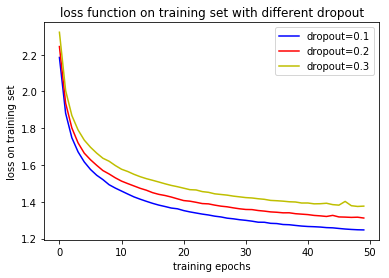

In [29]:
plt.title('loss function on training set with different dropout')
plt.xlabel('training epochs')
plt.ylabel('loss on training set')
plt.plot(range(num_epoch),train_drop_1,'b-',label='dropout=0.1')
plt.plot(range(num_epoch),train_drop_2,'r-',label='dropout=0.2')
plt.plot(range(num_epoch),train_drop_3,'y-',label='dropout=0.3')
#plt.ylim(1,1.2)
plt.legend(loc='upper right')
plt.show()

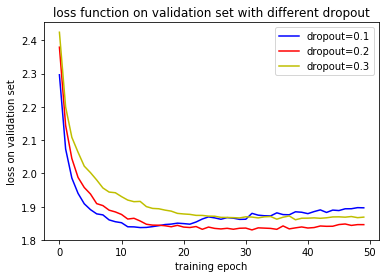

In [30]:
plt.title('loss function on validation set with different dropout')
plt.xlabel('training epoch')
plt.ylabel('loss on validation set')
plt.plot(range(num_epoch),valid_drop_1,'b-',label='dropout=0.1')
plt.plot(range(num_epoch),valid_drop_2,'r-',label='dropout=0.2')
plt.plot(range(num_epoch),valid_drop_3,'y-',label='dropout=0.3')
plt.legend(loc='upper right')
plt.show()

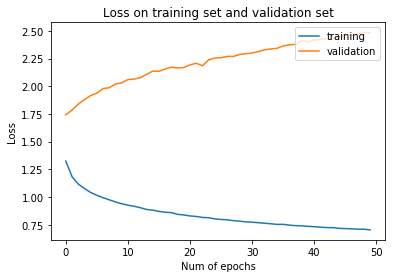

In [92]:
plt.title('Loss on training set and validation set')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.plot(range(num_epoch),train_drop_2,label='training')
plt.plot(range(num_epoch),valid_drop_2,label='validation')
plt.legend(loc='upper right')
plt.show()

In [19]:
def write_file(path):
    w = open(path,'a')
    x = lstmNet.state_dict()
    for i in x:
        w.write(i)
        w.write('\n')
        xx = x[i].cpu().numpy()
        if i[4] == 'b':
            l1 = len(xx)
            for t in range(l1):
                w.write(str(xx[t]))
                w.write(' ')
            w.write('\n')
        else:
            l1 = len(xx)
            l2 = len(xx[0])
            for t1 in range(l1):
                for t2 in range(l2):
                    w.write(str(xx[t1,t2]))
                    w.write(' ')
                w.write('\n')
        print(i,', done!')
    print('Finish!')

In [23]:
write_file('state.txt')

rnn.weight_ih_l0 , done!
rnn.weight_hh_l0 , done!
rnn.bias_ih_l0 , done!
rnn.bias_hh_l0 , done!
out.weight , done!
out.bias , done!
Finish!


In [ ]:
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.0).type(dfloat)
optimizer = optim.RMSprop(lstmNet.parameters(), lr=4e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers,',dropout=',lstmNet.dropout)
train_0, valid_0 = train_process(num_epoch)

In [ ]:
train_0

In [ ]:
valid_0

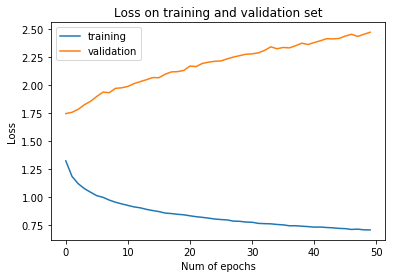

In [32]:
plt.title('Loss on training and validation set')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.plot(range(num_epoch),train_layer_2,label='training')
plt.plot(range(num_epoch),valid_layer_2,label='validation')
plt.legend(loc='best')
plt.show()

lstm: n_layers = 1, hidden_size = 50/75/100, dropout = 0.2

batch_size = 128

sequence_size = 30 every epoch += 2

optimizer: Adam with lr=4e-3

num_epoch = 50

scheduler: decay 0.5 every 10 epochs

In [77]:
n_layers = 1
train_hidden = []
valid_hidden = []
for hidden_size in [50, 75, 100]:
    lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.2).type(dfloat)
    optimizer = optim.Adam(lstmNet.parameters(), lr=4e-3)
    print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers)
    tl,vl = 0,0
    tl,vl = train_process(num_epoch)
    train_hidden.append(tl)
    valid_hidden.append(vl)

TestRNN (
  (rnn): LSTM(95, 50, dropout=0.2)
  (out): Linear (50 -> 95)
) seq= 30 ,hidden_size= 50 ,batch_size= 128 ,n_layers= 1
2018-02-28 14:19:37
[Epoch 1 Iter 1000]train_loss:1.835199
[Epoch 1 Iter 2000]train_loss:1.730867
[Epoch 1 Iter 3000]train_loss:1.602093
2018-02-28 14:19:59 train:1.585144, valid:1.869858
[Epoch 2 Iter 1000]train_loss:1.591282
[Epoch 2 Iter 2000]train_loss:1.378658
[Epoch 2 Iter 3000]train_loss:1.472505
2018-02-28 14:20:20 train:1.501002, valid:1.822848
[Epoch 3 Iter 1000]train_loss:1.600003
[Epoch 3 Iter 2000]train_loss:1.456156
[Epoch 3 Iter 3000]train_loss:1.465878
2018-02-28 14:20:42 train:1.463176, valid:1.825041
[Epoch 4 Iter 1000]train_loss:1.381904
[Epoch 4 Iter 2000]train_loss:1.355028
[Epoch 4 Iter 3000]train_loss:1.430237
2018-02-28 14:21:04 train:1.444589, valid:1.825514
[Epoch 5 Iter 1000]train_loss:1.433187
[Epoch 5 Iter 2000]train_loss:1.504011
[Epoch 5 Iter 3000]train_loss:1.405810
2018-02-28 14:21:25 train:1.430344, valid:1.823809
[Epoch 6 It

[Epoch 48 Iter 2000]train_loss:1.332547
[Epoch 48 Iter 3000]train_loss:1.381822
2018-02-28 14:37:07 train:1.364117, valid:1.818911
[Epoch 49 Iter 1000]train_loss:1.338250
[Epoch 49 Iter 2000]train_loss:1.266147
[Epoch 49 Iter 3000]train_loss:1.309451
2018-02-28 14:37:28 train:1.362945, valid:1.825469
[Epoch 50 Iter 1000]train_loss:1.357588
[Epoch 50 Iter 2000]train_loss:1.393976
[Epoch 50 Iter 3000]train_loss:1.344558
2018-02-28 14:37:50 train:1.364957, valid:1.811007
TestRNN (
  (rnn): LSTM(95, 75, dropout=0.2)
  (out): Linear (75 -> 95)
) seq= 30 ,hidden_size= 75 ,batch_size= 128 ,n_layers= 1
2018-02-28 14:37:50
[Epoch 1 Iter 1000]train_loss:1.721169
[Epoch 1 Iter 2000]train_loss:1.620773
[Epoch 1 Iter 3000]train_loss:1.510177
2018-02-28 14:38:12 train:1.472066, valid:1.806968
[Epoch 2 Iter 1000]train_loss:1.464509
[Epoch 2 Iter 2000]train_loss:1.365947
[Epoch 2 Iter 3000]train_loss:1.311997
2018-02-28 14:38:34 train:1.371645, valid:1.784448
[Epoch 3 Iter 1000]train_loss:1.369002
[Ep

[Epoch 45 Iter 3000]train_loss:1.173611
2018-02-28 14:53:11 train:1.225864, valid:1.891511
[Epoch 46 Iter 1000]train_loss:1.249187
[Epoch 46 Iter 2000]train_loss:1.256168
[Epoch 46 Iter 3000]train_loss:1.227866
2018-02-28 14:53:34 train:1.227215, valid:1.909803
[Epoch 47 Iter 1000]train_loss:1.259617
[Epoch 47 Iter 2000]train_loss:1.282625
[Epoch 47 Iter 3000]train_loss:1.143146
2018-02-28 14:53:57 train:1.232910, valid:1.913674
[Epoch 48 Iter 1000]train_loss:1.165716
[Epoch 48 Iter 2000]train_loss:1.237894
[Epoch 48 Iter 3000]train_loss:1.240814
2018-02-28 14:54:18 train:1.227821, valid:1.902219
[Epoch 49 Iter 1000]train_loss:1.254153
[Epoch 49 Iter 2000]train_loss:1.197600
[Epoch 49 Iter 3000]train_loss:1.238658
2018-02-28 14:54:39 train:1.225511, valid:1.900422
[Epoch 50 Iter 1000]train_loss:1.220725
[Epoch 50 Iter 2000]train_loss:1.255336
[Epoch 50 Iter 3000]train_loss:1.171532
2018-02-28 14:54:58 train:1.226051, valid:1.901154
TestRNN (
  (rnn): LSTM(95, 100, dropout=0.2)
  (out):

2018-02-28 15:09:58 train:1.126756, valid:1.917336
[Epoch 43 Iter 1000]train_loss:1.122981
[Epoch 43 Iter 2000]train_loss:1.184360
[Epoch 43 Iter 3000]train_loss:1.088429
2018-02-28 15:10:20 train:1.127191, valid:1.931655
[Epoch 44 Iter 1000]train_loss:1.114412
[Epoch 44 Iter 2000]train_loss:1.201692
[Epoch 44 Iter 3000]train_loss:1.154365
2018-02-28 15:10:42 train:1.129272, valid:1.926917
[Epoch 45 Iter 1000]train_loss:1.134433
[Epoch 45 Iter 2000]train_loss:1.177787
[Epoch 45 Iter 3000]train_loss:1.161043
2018-02-28 15:11:04 train:1.129733, valid:1.925535
[Epoch 46 Iter 1000]train_loss:1.094085
[Epoch 46 Iter 2000]train_loss:1.158371
[Epoch 46 Iter 3000]train_loss:1.112223
2018-02-28 15:11:25 train:1.128465, valid:1.927584
[Epoch 47 Iter 1000]train_loss:1.132762
[Epoch 47 Iter 2000]train_loss:1.128985
[Epoch 47 Iter 3000]train_loss:1.130813
2018-02-28 15:11:48 train:1.130583, valid:1.929259
[Epoch 48 Iter 1000]train_loss:1.183089
[Epoch 48 Iter 2000]train_loss:1.092649
[Epoch 48 Iter

In [78]:
hidden_sizeee = 150
lstmNet = TestRNN(input_size, hidden_size, batch_size, model="lstm", n_layers=n_layers,dropout=0.2).type(dfloat)
optimizer = optim.Adam(lstmNet.parameters(), lr=4e-3)
print(lstmNet, 'seq=',lstmNet.input_size, ',hidden_size=',lstmNet.hidden_size,',batch_size=',lstmNet.batch_size, ',n_layers=',lstmNet.n_layers)
tl,vl = 0,0
tl,vl = train_process(num_epoch)
train_hidden.append(tl)
valid_hidden.append(vl)

TestRNN (
  (rnn): LSTM(95, 150, dropout=0.2)
  (out): Linear (150 -> 95)
) seq= 30 ,hidden_size= 150 ,batch_size= 128 ,n_layers= 1
2018-02-28 15:12:54
[Epoch 1 Iter 1000]train_loss:1.496996
[Epoch 1 Iter 2000]train_loss:1.361667
[Epoch 1 Iter 3000]train_loss:1.334979
2018-02-28 15:13:18 train:1.275320, valid:1.758733
[Epoch 2 Iter 1000]train_loss:1.242535
[Epoch 2 Iter 2000]train_loss:1.239796
[Epoch 2 Iter 3000]train_loss:1.160601
2018-02-28 15:13:41 train:1.138230, valid:1.823866
[Epoch 3 Iter 1000]train_loss:1.103074
[Epoch 3 Iter 2000]train_loss:1.087045
[Epoch 3 Iter 3000]train_loss:0.976739
2018-02-28 15:14:04 train:1.083258, valid:1.874682
[Epoch 4 Iter 1000]train_loss:1.096105
[Epoch 4 Iter 2000]train_loss:1.037115
[Epoch 4 Iter 3000]train_loss:1.123661
2018-02-28 15:14:27 train:1.052795, valid:1.912988
[Epoch 5 Iter 1000]train_loss:1.068309
[Epoch 5 Iter 2000]train_loss:1.044552
[Epoch 5 Iter 3000]train_loss:0.993905
2018-02-28 15:14:51 train:1.031139, valid:1.938931
[Epoch 6

[Epoch 48 Iter 2000]train_loss:0.928420
[Epoch 48 Iter 3000]train_loss:0.929343
2018-02-28 15:31:35 train:0.922176, valid:2.234131
[Epoch 49 Iter 1000]train_loss:0.937430
[Epoch 49 Iter 2000]train_loss:0.958164
[Epoch 49 Iter 3000]train_loss:0.988698
2018-02-28 15:31:59 train:0.920624, valid:2.205661
[Epoch 50 Iter 1000]train_loss:0.938424
[Epoch 50 Iter 2000]train_loss:0.918212
[Epoch 50 Iter 3000]train_loss:0.961640
2018-02-28 15:32:22 train:0.918539, valid:2.203877


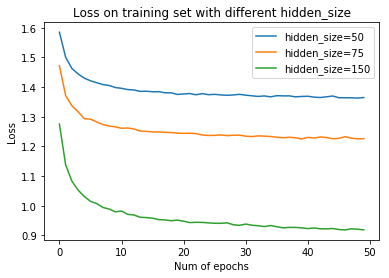

In [81]:
plt.title('Loss on training set with different hidden_size')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.plot(range(num_epoch),train_hidden[0],label='hidden_size=50')
plt.plot(range(num_epoch),train_hidden[1],label='hidden_size=75')
plt.plot(range(num_epoch),train_hidden[3],label='hidden_size=150')
plt.legend(loc='upper right')
plt.show()

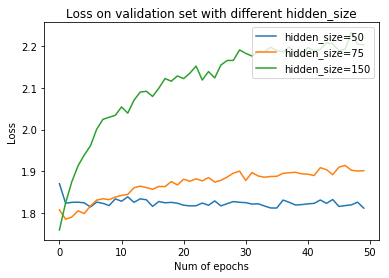

In [82]:
plt.title('Loss on validation set with different hidden_size')
plt.xlabel('Num of epochs')
plt.ylabel('Loss')
plt.plot(range(num_epoch),valid_hidden[0],label='hidden_size=50')
plt.plot(range(num_epoch),valid_hidden[1],label='hidden_size=75')
plt.plot(range(num_epoch),valid_hidden[3],label='hidden_size=150')
plt.legend(loc='upper right')
plt.show()

In [31]:
lstmNet.input_size = 1
lstmNet.batch_size = 1
T = 0.5

In [32]:
def flip_coin(prob):
    choice = np.random.choice(np.arange(output_size),p=prob)
    return choice

In [33]:
def generate(start_ch):
    rst = ""
    rst += start_ch
    n = char_to_indx[start_ch]
    lstmNet.init_hidden(1)
    while indx_to_char[n] != '%':
        x = torch.zeros(1,1,output_size)
        x[0,0,n] = 1
        x = autograd.Variable(x.type(dfloat))
        score = lstmNet(x)
        prob = F.softmax(score/T)
        prob = prob.cpu().data.numpy().reshape(output_size,)
        n = flip_coin(prob)
        rst += indx_to_char[n]
    return rst

In [43]:
print((generate('$')))

$
X:22
T:Mistunerder the ores, | faf2 | e2d2 | e2d2 | d2d2 | g2e2 | d2e2 | d2e2 | d2c2 | d2c2 | c2d2 | B2A2 | B2dB | B2 z2 | B2!breath! A3 | B2B | B2B | B2B | B2B | B3 | B2B|BBB | B2B | BBB | BBB | B2B | B2B | B2B | B2B | BBB | B GB | BB/B/BB | B3 BBB | BB/B/BB | BB/B/BB | BBG | B2B/B/B/_B/ | B2B | B2B2 | B2B2 | B2B2 | B2BB | BBAB| | B2B2 | B>B:|
%
